In [1]:
import rnn, vae, config
import torch
import numpy as np
import matplotlib.pyplot as plt
import train_rnn
import train_vae
import json
import scipy.linalg as linalg
import os

dim_latent_z = 8

In [2]:
random_index = 22
lambda_sv = 64.0
state_vars_to_predict = [9, 10, 11]
detach_gradients = False
use_layernorm = False
truncate_at_batch = 40
n_hidden = 128
train_epochs = 250
save_every_epochs = 50
max_gradient_norm = 100.0
lr = 0.001
random_index = random_index
lambda_sv = lambda_sv
epoch = 500

sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict) > 0 else 'X'
rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
         f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{epoch}.pt', map_location=config.device))
n_gaussians = rnn_model.n_gaussians

In [3]:
def load_data(suffix="", length_cutoff=301):
    batch_size = 256
    n_batches, mean_batches, var_batches, state_vars_batches, \
        action_batches, mask_batches, end_flag_batches = \
        train_rnn.load_data(f'data/vae_preprocessed_{dim_latent_z}dimlatent{suffix}.npz', 
                                            f'data/vae_rollouts_env_vars{suffix}.npz', batch_size = batch_size,
                           truncate_at_batch=None)
    episode_len = ([torch.nonzero(end_flags)[:, 1] for end_flags in end_flag_batches])
    filtered_episodes = []
    for i in range(len(episode_len)):
        for j in range(len(episode_len[i])):
            if episode_len[i][j] >= length_cutoff:
                episode_data = {
                    'mean': mean_batches[i][j, :length_cutoff, :],
                    'var': var_batches[i][j, :length_cutoff, :],
                    'state_vars': state_vars_batches[i][j, :length_cutoff, :],
                    'action': action_batches[i][j, :length_cutoff, :],
                    'mask': mask_batches[i][j, :length_cutoff],
                    'end_flag': end_flag_batches[i][j, :length_cutoff, :],
                }
                filtered_episodes.append(episode_data)
    # Convert the filtered episodes to tensors
    filtered_episodes_tensor = {
        'mean': torch.stack([ep['mean'] for ep in filtered_episodes]),
        'var': torch.stack([ep['var'] for ep in filtered_episodes]),
        'state_vars': torch.stack([ep['state_vars'] for ep in filtered_episodes]),
        'action': torch.stack([ep['action'] for ep in filtered_episodes]),
        'mask': torch.stack([ep['mask'] for ep in filtered_episodes]),
        'end_flag': torch.stack([ep['end_flag'] for ep in filtered_episodes])
    } # shape of every tensor: [n_episodes, batch_size, dim_latent_z]
    n_episodes = filtered_episodes_tensor['mean'].shape[0]
    batch_size = n_episodes
    return n_episodes, filtered_episodes_tensor

In [25]:
def record_predictions(rnn_model, filtered_episodes_tensor, batch_size, cutoff_t=None):
    """
        Runs the RNN over the selected episodes
        (optionally detaching from the environment at t=cutoff_t, 
        and continuing with the outputted Z values put back in).
        Returns the following:
        z_pred_store: (every entry is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :])
        ef_store: tensor of size [batch_size, n_timesteps, 1]
        y_store: tensor of size [batch_size, n_timesteps, RNN_hidden_dim]
    """
    means = filtered_episodes_tensor['mean']
    vars = filtered_episodes_tensor['var']
    actions = filtered_episodes_tensor['action']
    masks = filtered_episodes_tensor['mask'][:, 1:]
    state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    inputs = torch.cat([z_values, actions], dim=2)[:, :-1] #(batch_size, n_timesteps, dim_latent_z+1)
    n_timesteps = inputs.shape[1]
    if cutoff_t is None: cutoff_t = n_timesteps
    
    z_pred_store = [] # every entry is (pi, mu, sigma); each is [batch_size, 1, n_gaussians, :]
    ef_store = [] # each entry is [batch_size, 1, 1]
    y_store = [] # each entry is [batch_size, 1, 1]
    with torch.no_grad():
        hidden = rnn_model.init_hidden(batch_size)
        for t in range(n_timesteps):
            if t < cutoff_t:
                # sample true input from environment
                inputs_t = inputs[:, t:t+1, :]
            else:
                # sample input from previous output of RNN
                pi, mu, sigma = z_pred_store[-1]
                sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, 1, 1, 1).repeat(1, 1, 1, dim_latent_z)
                mu_sampled = torch.gather(mu, 2, sampled_indices)
                sigma_sampled = torch.gather(sigma, 2, sampled_indices)
                z_sampled = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, 1, dim_latent_z)
                inputs_t = torch.cat([z_sampled, actions[:, t:t+1, :]], dim=2)
                
            # run RNN on this input and record result
            (pi, mu, sigma), ef, hidden, y = rnn_model(inputs_t, hidden)
            z_pred_store.append((pi, mu, sigma))
            ef_store.append(ef)
            y_store.append(y)
    return z_pred_store, torch.cat(ef_store, dim=1), torch.cat(y_store, dim=1)

In [ ]:
cutoff_t = None
n_episodes, filtered_episodes_tensor = load_data(suffix="")

In [28]:
def calculate_mse_losses(rnn_model):
    z_pred_store, ef_store, y_store = record_predictions(rnn_model, filtered_episodes_tensor, batch_size=n_episodes, cutoff_t=cutoff_t)

    means = filtered_episodes_tensor['mean']
    vars = filtered_episodes_tensor['var']
    actions = filtered_episodes_tensor['action']
    masks = filtered_episodes_tensor['mask'][:, 1:]
    state_vars = filtered_episodes_tensor['state_vars'][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    
    # Get the dimensions
    batch_size, n_timesteps, n_state_vars = state_vars.shape
    _, _, hidden_dim = y_store.shape
    # Create a list to store the best linear decoders for each state variable
    best_decoders = []
    mse_errors = []
    # Iterate over each state variable
    for i in range(n_state_vars):
        # Reshape y_store and state_vars for the current state variable
        # Starting decoding from 100 timesteps to avoid incorporating starting values (some of which are set arbitrary)
        X = y_store[:, 100:, :].reshape(-1, hidden_dim).numpy()
        y = state_vars[:, 100:, i].reshape(-1, 1).numpy()
        # Add a row of 1s to X for bias
        X_with_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        # Find the best linear decoder using least squares
        decoder_weights, residuals, _, _ = linalg.lstsq(X_with_bias, y)
        # Create a linear decoder with the obtained weights and bias
        decoder = torch.nn.Linear(hidden_dim, 1, bias=True)
        decoder.weight.data = torch.tensor(decoder_weights[:-1], dtype=torch.float32).reshape(1, -1)
        decoder.bias.data = torch.tensor(decoder_weights[-1], dtype=torch.float32)
        # Append the decoder to the list
        best_decoders.append(decoder)
        mse_errors.append(residuals.item() / len(y))
    return mse_errors, best_decoders

In [29]:
calculate_mse_losses(rnn_model)

([0.0064608414368907555,
  0.0010027705061499135,
  0.0010027705061499137,
  0.006309669030618895,
  0.0010561698240915253,
  0.001056169824091525,
  0.0004999924968861349,
  0.0044796605210106815,
  0.01768754551023632,
  0.000785134924419648,
  0.0003713169543842189,
  7.030121474613761e-05],
 [Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True),
  Linear(in_features=128, out_features=1, bias=True)])

In [ ]:
state_variables_names_fortitles =  [
    "the last pipe's\nhorizontal position",
    "the last top pipe's\nvertical position",
    "the last bottom pipe's\nvertical position",
    "the next pipe's\nhorizontal position",
    "the next top pipe's\nvertical position",
    "the next bottom pipe's\nvertical position",
    "the next next pipe's\nhorizontal position",
    "the next next top pipe's\nvertical position",
    "the next next bottom pipe's\nvertical position",
    "player's vertical position",
    "player's vertical velocity",
    "player's rotation",
]

In [68]:
print("observations\n\nenvironment")

observations

environment


In [82]:
rnn_epochs = list(range(50, 501, 50))
rnn_ids = [
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r7',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r11',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r17',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv3x4x5x9x10x11_lsv0.0_r39',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r24',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r27',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r28',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r31'
]
rnn_data = []
for rnn_id_i, rnn_id in enumerate(rnn_ids):
    state_vars_to_predict = [3, 4, 5, 9, 10, 11] if "3x4x5x9x10x11" in rnn_id else [9, 10, 11]
    rnn_data.append([])
    for calculate_loss_at_batch in rnn_epochs:
        rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=False).to(config.device)
        rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{calculate_loss_at_batch}.pt', map_location=config.device))
        n_gaussians = rnn_model.n_gaussians
        
        rnn_data[rnn_id_i].append(calculate_mse_losses(rnn_model))
    print(rnn_id)

_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r7
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r11
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r17
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv3x4x5x9x10x11_lsv0.0_r39
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r24
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r27
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r28
_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r31


In [79]:
n_untrained_rnns = 5
rnn_data_untrained = []
for i in range(n_untrained_rnns):
    rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=False).to(config.device)
    rnn_data_untrained.append(calculate_mse_losses(rnn_model))

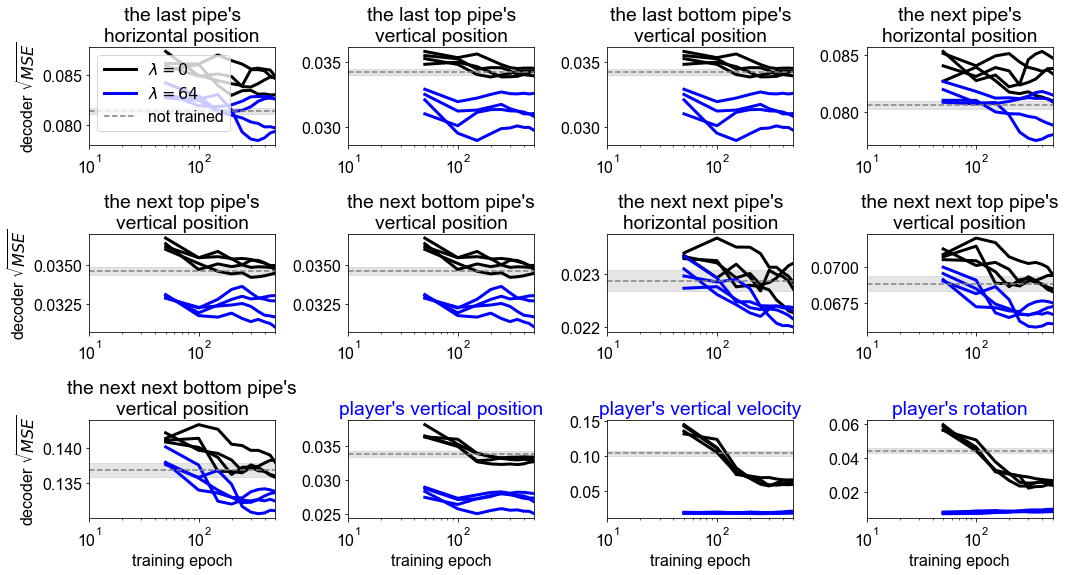

In [88]:
plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
fig, axes = plt.subplots(3, 4, figsize=(15, 9))  # Create a 3x4 grid of subplots

for sv_i, sv_name in enumerate(state_variables_names_fortitles):
    ax = axes[sv_i // 4, sv_i % 4]  # Select the appropriate subplot

    max_yvalue = 0
    for rnn_id_i, rnn_id in enumerate(rnn_ids):
        y_values = [rnn_data[rnn_id_i][x_i][0][sv_i]**0.5 for x_i in range(len(rnn_epochs))]
        label = "$\lambda = 0$" if rnn_id_i == 0 else "$\lambda = 64$" if rnn_id_i == 4 else None
        color = "black" if rnn_id_i<4 else "blue"
        ax.plot(rnn_epochs, y_values, linewidth=3, color=color, label=label)
        max_yvalue = max(max_yvalue, max(y_values))

    untrained_y_values = [rnn_data_untrained[i][0][sv_i]**0.5 for i in range(n_untrained_rnns)]
    untrained_y_value_mean = np.mean(untrained_y_values)
    untrained_y_value_sd = np.std(untrained_y_values)
    max_yvalue = max(max_yvalue, untrained_y_value_mean)
    ax.plot([10, 500], [untrained_y_value_mean, untrained_y_value_mean], "--", color="gray", label="not trained")
    # Plot the shaded region around the untrained networks according to the standard deviation
    ax.fill_between([10, 500],
                    [untrained_y_value_mean - untrained_y_value_sd, untrained_y_value_mean - untrained_y_value_sd],
                    [untrained_y_value_mean + untrained_y_value_sd, untrained_y_value_mean + untrained_y_value_sd],
                    color="gray", alpha=0.2)

    ax.set_xscale('log')
    ax.set_xlim(10, 500)
    #ax.set_ylim(0, max_yvalue*1.1)
    ax.set_title(sv_name, color="black" if sv_i<9 else "blue")  # Set the title for each subplot
    
    if (sv_i // 4) == 2: 
        ax.set_xlabel("training epoch")
    if (sv_i % 4) == 0:
        ax.set_ylabel("decoder $\sqrt{MSE}$")
    if sv_i==0:
        ax.legend()
# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter as needed
plt.show()

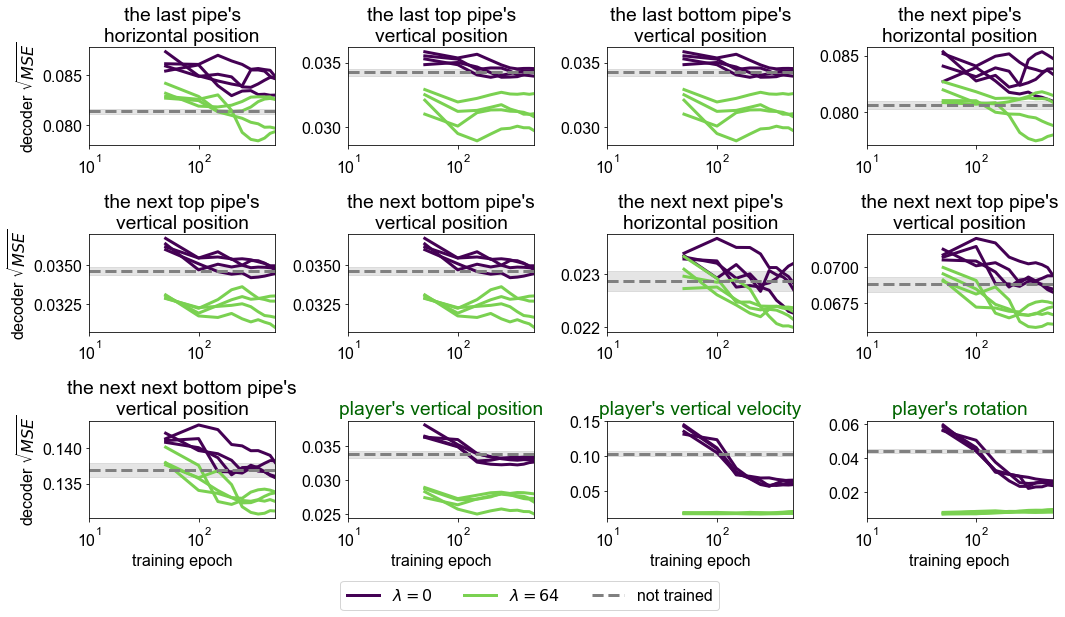

In [117]:
plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})

fig, axes = plt.subplots(3, 4, figsize=(15, 9))  # Create a 3x4 grid of subplots

for sv_i, sv_name in enumerate(state_variables_names_fortitles):
    ax = axes[sv_i // 4, sv_i % 4]  # Select the appropriate subplot
    max_yvalue = 0
    
    for rnn_id_i, rnn_id in enumerate(rnn_ids):
        y_values = [rnn_data[rnn_id_i][x_i][0][sv_i]**0.5 for x_i in range(len(rnn_epochs))]
        label = "$\\lambda = 0$" if rnn_id_i == 0 else "$\\lambda = 64$" if rnn_id_i == 4 else None
        color = plt.cm.get_cmap('viridis')(np.linspace(0, .8, len(lambda_svs)))[0 if rnn_id_i < 4 else 1]
        ax.plot(rnn_epochs, y_values, linewidth=3, color=color, label=label)
        max_yvalue = max(max_yvalue, max(y_values))
    
    untrained_y_values = [rnn_data_untrained[i][0][sv_i]**0.5 for i in range(n_untrained_rnns)]
    untrained_y_value_mean = np.mean(untrained_y_values)
    untrained_y_value_sd = np.std(untrained_y_values)
    max_yvalue = max(max_yvalue, untrained_y_value_mean)
    
    ax.plot([10, 500], [untrained_y_value_mean, untrained_y_value_mean], "--", color="gray", label="not trained", linewidth=3)
    
    # Plot the shaded region around the untrained networks according to the standard deviation
    ax.fill_between([10, 500],
                    [untrained_y_value_mean - untrained_y_value_sd, untrained_y_value_mean - untrained_y_value_sd],
                    [untrained_y_value_mean + untrained_y_value_sd, untrained_y_value_mean + untrained_y_value_sd],
                    color="gray", alpha=0.2)
    
    ax.set_xscale('log')
    ax.minorticks_off()
    ax.set_xlim(10, 500)
    #ax.set_xticks([50, 100, 500])
    ax.minorticks_off()
    # ax.set_ylim(0, max_yvalue*1.1)
    color = plt.cm.get_cmap('viridis')(np.linspace(0, .5, len(lambda_svs)))[1]
    color="darkgreen"
    ax.set_title(sv_name, color=color if sv_i>8 else "black")  # Set the title for each subplot
    
    if (sv_i // 4) == 2:
        ax.set_xlabel("training epoch")
    
    if (sv_i % 4) == 0:
        ax.set_ylabel("decoder $\\sqrt{MSE}$")

# Adjust the spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter as needed

# Create a horizontal legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, -0.02))

plt.show()

In [32]:
lambda_svs = [0.0, 64.0]
losses = [[] for lambda_sv in lambda_svs]
for lambda_sv_i, lambda_sv in enumerate(lambda_svs):
    for random_index in (range(20, 40) if lambda_sv_i>0 else range(40)):
        color = plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(lambda_svs)))[lambda_sv_i]
        state_vars_to_predict = [9, 10, 11]
        detach_gradients = False
        use_layernorm = False
        truncate_at_batch = 40
        n_hidden = 128
        train_epochs = 250
        save_every_epochs = 50
        max_gradient_norm = 100.0
        lr = 0.001
        random_index = random_index
        lambda_sv = lambda_sv
        dim_latent_z = 8
        #if lambda_sv == 0: state_vars_to_predict = []
        
        sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict)>0 else 'X'
        rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
                 f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

        last_epoch = 0
        for file in os.listdir(f"data/rnn{rnn_id}/"):
            if file.startswith("rnn_model_epoch") and file.endswith(".pt"):
                epoch_num = int(file.split("epoch")[1].split(".")[0])
                if epoch_num > last_epoch:
                    last_epoch = epoch_num
        if last_epoch < 500: continue

        print(f"'{rnn_id}',")

'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r7',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r11',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv0.0_r17',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r22',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r23',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r24',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r27',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r28',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv9x10x11_lsv64.0_r31',


In [80]:
lambda_svs = [0.0, 64.0]
losses = [[] for lambda_sv in lambda_svs]
for lambda_sv_i, lambda_sv in enumerate(lambda_svs):
    for random_index in (range(20, 40)):
        color = plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(lambda_svs)))[lambda_sv_i]
        state_vars_to_predict = [3, 4, 5, 9, 10, 11]
        detach_gradients = False
        use_layernorm = False
        truncate_at_batch = 40
        n_hidden = 128
        train_epochs = 250
        save_every_epochs = 50
        max_gradient_norm = 100.0
        lr = 0.001
        random_index = random_index
        lambda_sv = lambda_sv
        dim_latent_z = 8
        #if lambda_sv == 0: state_vars_to_predict = []
        
        sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict)>0 else 'X'
        rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
                 f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

        last_epoch = 0
        for file in os.listdir(f"data/rnn{rnn_id}/"):
            if file.startswith("rnn_model_epoch") and file.endswith(".pt"):
                epoch_num = int(file.split("epoch")[1].split(".")[0])
                if epoch_num > last_epoch:
                    last_epoch = epoch_num
        if last_epoch < 500: continue

        print(f"'{rnn_id}',")

'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv3x4x5x9x10x11_lsv0.0_r39',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv3x4x5x9x10x11_lsv64.0_r27',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv3x4x5x9x10x11_lsv64.0_r31',
'_ln0_nh128_dlz8_mgn100.0_lr0.001_dg0_da40_sv3x4x5x9x10x11_lsv64.0_r37',


In [ ]:
calculate_loss_at_batch = 300

lambda_svs = [0.0, 4.0, 8.0, 16.0, 32.0, 64.0]
losses = [[] for lambda_sv in lambda_svs]
for lambda_sv_i, lambda_sv in enumerate(lambda_svs):
    for random_index in (range(20, 40) if lambda_sv_i>0 else range(40)):
        print(lambda_sv, end="; ")
        color = plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(lambda_svs)))[lambda_sv_i]
        state_vars_to_predict = [9, 10, 11]
        detach_gradients = False
        use_layernorm = False
        truncate_at_batch = 40
        n_hidden = 128
        train_epochs = 250
        save_every_epochs = 50
        max_gradient_norm = 100.0
        lr = 0.001
        random_index = random_index
        lambda_sv = lambda_sv
        dim_latent_z = 8
        #if lambda_sv == 0: state_vars_to_predict = []
        
        sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict)>0 else 'X'
        rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
                 f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

        last_epoch = 0
        for file in os.listdir(f"data/rnn{rnn_id}/"):
            if file.startswith("rnn_model_epoch") and file.endswith(".pt"):
                epoch_num = int(file.split("epoch")[1].split(".")[0])
                if epoch_num > last_epoch:
                    last_epoch = epoch_num
        if last_epoch < calculate_loss_at_batch: continue

        rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
        rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{calculate_loss_at_batch}.pt', map_location=config.device))
        n_gaussians = rnn_model.n_gaussians